In [2]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
import utils_vis
%matplotlib inline

(155, 240, 240, 5)


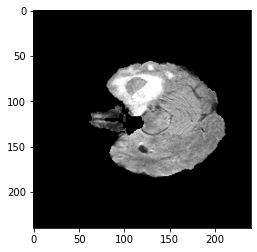

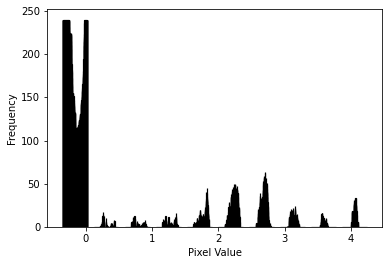

In [3]:
img_path = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/Training_pre/'
patient = sorted(os.listdir(img_path))[0] #Brats2020_Training01.npy
patient_path = os.path.join(img_path, patient)
patient_img = np.load(patient_path)

print(patient_img.shape)
plt.imshow(patient_img[50,...,0],cmap='gray')
plt.show()

#plot histogram
plt.hist(patient_img[50,...,0], edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

To check the min. max. value of each MRI modalities with standardization

In [3]:
for i in range(4):
    print('Channel {}'.format(i))
    print('Max val: {} '.format(np.max(patient_img[...,i])))
    print('Min val: {} '.format(np.min(patient_img[...,i])))
    print()

Channel 0
Max val: 4.286220550537109 
Min val: -0.39467811584472656 

Channel 1
Max val: 3.2409584522247314 
Min val: -0.4079514145851135 

Channel 2
Max val: 3.213397979736328 
Min val: -0.409527450799942 

Channel 3
Max val: 4.384477138519287 
Min val: -0.3892749547958374 



Min Max Norm of standardized image

Channel 0
Max val: 1.0 
Min val: 0.0 

Channel 1
Max val: 1.0 
Min val: 0.0 

Channel 2
Max val: 1.0 
Min val: 0.0 

Channel 3
Max val: 1.0 
Min val: 0.0 

(155, 240, 240, 5)


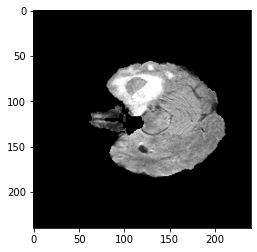

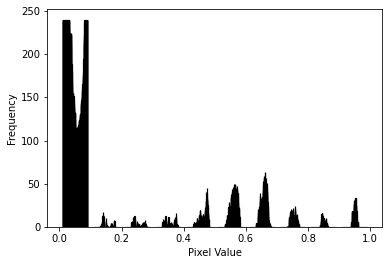

In [7]:
patient_img_minmax = utils.normalize_modalities(patient_img[...,:4], mode='minmax')
for i in range(4):
    print('Channel {}'.format(i))
    print('Max val: {} '.format(np.max(patient_img_minmax[...,i])))
    print('Min val: {} '.format(np.min(patient_img_minmax[...,i])))
    print()

print(patient_img.shape)
plt.imshow(patient_img_minmax[50,...,0],cmap='gray')
plt.show()

#plot histogram
plt.hist(patient_img_minmax[50,...,0], edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


Finding Boundary

In [7]:
inp_img = patient_img_minmax

def boundary_search(inp_img, mode=None):
    '''
    Boundary search for right, left, top, bottom
    :param inp_img: Input image
    :param mode: 'left', 'right', 'top', 'bottom'
    :return: boundary index
    '''
    assert mode!=None, 'Please insert [mode], "left", "right", "top", "bottom"'
    for i in range(240):
        for j in range(240):
            if mode=='left': # check left boundary
                if inp_img[j, i] != 0.0:
                    break
            if mode=='right': # check right boundary
                if inp_img[239-j, 239-i] != 0.0:
                    break
            if mode=='top': # check top boundary
                if inp_img[i, j] != 0.0:
                    break
            if mode=='bottom': #c heck bottom boundary
                if inp_img[230-i, 239-j] != 0.0:
                    break
        if mode=='left': # check left boundary
            if inp_img[j, i] != 0.0:
                break
        if mode=='right': # check right boundary
            if inp_img[239-j, 239-i] != 0.0:
                break
        if mode=='top': # check top boundary
            if inp_img[i, j] != 0.0:
                break
        if mode=='bottom': #c heck bottom boundary
            if inp_img[230-i, 239-j] != 0.0:
                break
    return i

boundary = ['left', 'right', 'top', 'bottom']
modalities = ['Flair', 'T1', 'T2', 'T2ce']
slices = [50, 75, 100]
for s in slices:
    print("-----------------------")
    print("Slice: {}".format(s))
    print()
    for i, m in enumerate(modalities):
        print("Modalities: {}".format(m))
        for b in boundary:
            print('{} boundary index: {}'.format(b, boundary_search(inp_img[s,...,i], b)))
        print()
        print("----------------------------------")
        print()

-----------------------
Slice: 50

Modalities: Flair
left boundary index: 62
right boundary index: 28
top boundary index: 56
bottom boundary index: 46

----------------------------------

Modalities: T1
left boundary index: 62
right boundary index: 28
top boundary index: 56
bottom boundary index: 46

----------------------------------

Modalities: T2
left boundary index: 62
right boundary index: 28
top boundary index: 56
bottom boundary index: 46

----------------------------------

Modalities: T2ce
left boundary index: 62
right boundary index: 28
top boundary index: 56
bottom boundary index: 46

----------------------------------

-----------------------
Slice: 75

Modalities: Flair
left boundary index: 43
right boundary index: 26
top boundary index: 52
bottom boundary index: 48

----------------------------------

Modalities: T1
left boundary index: 43
right boundary index: 26
top boundary index: 52
bottom boundary index: 48

----------------------------------

Modalities: T2
left bo

Find max boundary for a given patient

In [8]:
boundary = ['left', 'right', 'top', 'bottom']

outer_list = []
for s in range(155):
    inner_list = []
    for b in boundary:
        bs = boundary_search(inp_img[s,...,0], b)
        inner_list.append(bs)
    outer_list.append(inner_list)
output= np.array(outer_list)

print(output.shape)

(155, 4)


In [9]:
max_boundary = np.min(output, axis=0)
print("Max boundary: {}".format(max_boundary))

Max boundary: [42 25 49 45]


# Crop and Padding

In [10]:
# crop
crop_patient_img = patient_img_minmax[:,20:220,20:220,:]
print(crop_patient_img.shape)

#pad
padding = tf.constant([[0,0],[20,20],[20,20],[0,0]]) # pad for top,down,left right
pad_patient_img = tf.pad(crop_patient_img, padding, "CONSTANT")
print(pad_patient_img.shape)

(155, 200, 200, 5)
(155, 240, 240, 5)


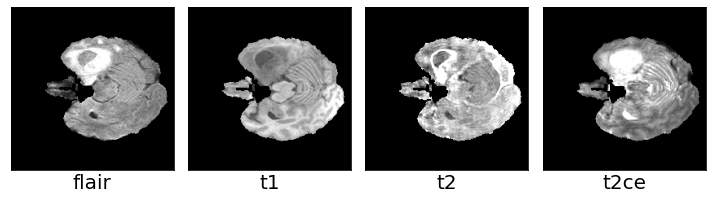

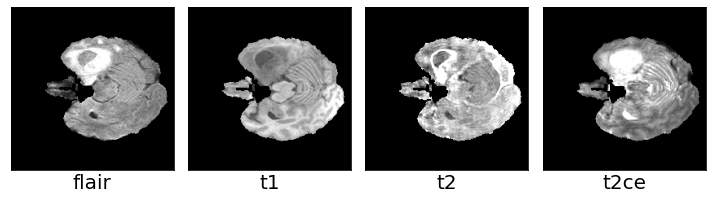

In [11]:
slice = 50
std_imgs = [patient_img[slice,20:220,20:220,i] for i in range(4)]
minmax_imgs = [patient_img_minmax[slice,20:220,20:220,i] for i in range(4)]
captions = ['flair','t1','t2','t2ce']
utils_vis.plot_comparison(std_imgs, captions, n_col=len(captions), figsize=(10,10))
utils_vis.plot_comparison(minmax_imgs, captions, n_col=len(captions), figsize=(10,10))

# Checking top and down empty slices 